In [2]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

In [3]:
##scd version
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)#parameters initialized with create_setup
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)


In [4]:
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}#attrs to print the units on graphs
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u


In [5]:
@xs.process
class AdvectionLax:
    """Advection using finite difference (Lax method) on
    a fixed grid with periodic boundary conditions.

    """

    v = xs.variable(dims=[(), "x"], description="velocity")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_advected = xs.variable(dims="x", intent="out", groups="u_vars")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        factor = self.v / (2 * self.grid_spacing)

        u_left = np.roll(self.u, 1)
        u_right = np.roll(self.u, -1)
        u_1 = 0.5 * (u_right + u_left) - factor * dt * (u_right - u_left)

        self.u_advected = u_1 - self.u

In [6]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [7]:
# CREATE xs.Model
advect_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "advect": AdvectionLax,
    }
)


In [8]:
advect_model

<xsimlab.Model (4 processes, 5 inputs)>
grid
    spacing     [in] uniform spacing
    length      [in] total length
init
    loc         [in] location of initial pulse
    scale       [in] scale of initial pulse
advect
    v           [in] () or ('x',) velocity
profile

In [34]:
#CREATE SET UP
in_ds = xs.create_setup(model=advect_model, 
                        clocks={'time': np.linspace(0., 1., 101),
                                'otime': [0, 0.25, 0.5,0.75, 1]}, 
                        master_clock='time',
                        input_vars={'grid': {'length': 1.5, 'spacing': 0.01},#INITIALISATION
                                    'init': {'loc': 0.3, 'scale': 0.1},
                                    'advect__v': 1.},
                        output_vars={'profile__u': 'otime'})


In [35]:
in_ds

<xarray.Dataset>
Dimensions:        (otime: 5, time: 101)
Coordinates:
  * time           (time) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
  * otime          (otime) float64 0.0 0.25 0.5 0.75 1.0
Data variables:
    grid__length   float64 1.5
    grid__spacing  float64 0.01
    init__loc      float64 0.3
    init__scale    float64 0.1
    advect__v      float64 1.0

In [36]:
out_ds = in_ds.xsimlab.run(model=advect_model)

In [37]:
out_ds.profile__u.sel(x=0.75)

<xarray.DataArray 'profile__u' (otime: 5)>
array([1.60522806e-09, 1.83156389e-02, 7.78800783e-01, 1.23409804e-04,
       6.38150345e-40])
Coordinates:
  * otime    (otime) float64 0.0 0.25 0.5 0.75 1.0
    x        float64 0.75
Attributes:
    description:  quantity u
    units:        m

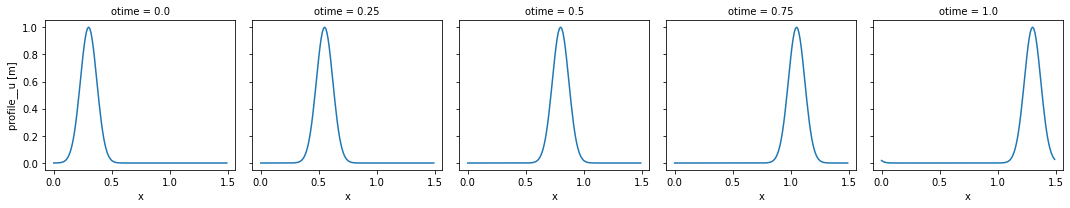

In [39]:
out_ds.profile__u.plot(col='otime', figsize=(15, 3));

In [40]:
in_ds_vel = in_ds.xsimlab.update_vars(#DIFFERENT VELOCITIES
    model=advect_model,
    input_vars={'advect__v': ('batch', [1.0, 0.5, 0.2,0.05])}#velocity v will sucessively be 1.0, 0.5, and 0.2, the 'batch' parameter allows to run one simulation for each value of velocity
)

In [41]:
out_ds_vel = in_ds_vel.xsimlab.run(model=advect_model, batch_dim='batch')

In [42]:
out_ds_vel

<xarray.Dataset>
Dimensions:        (batch: 4, otime: 5, time: 101, x: 150)
Coordinates:
  * otime          (otime) float64 0.0 0.25 0.5 0.75 1.0
  * time           (time) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
  * x              (x) float64 0.0 0.01 0.02 0.03 0.04 ... 1.46 1.47 1.48 1.49
Dimensions without coordinates: batch
Data variables:
    advect__v      (batch) float64 1.0 0.5 0.2 0.05
    grid__length   float64 1.5
    grid__spacing  float64 0.01
    init__loc      float64 0.3
    init__scale    float64 0.1
    profile__u     (batch, otime, x) float64 0.0001234 0.0002226 ... 0.007665

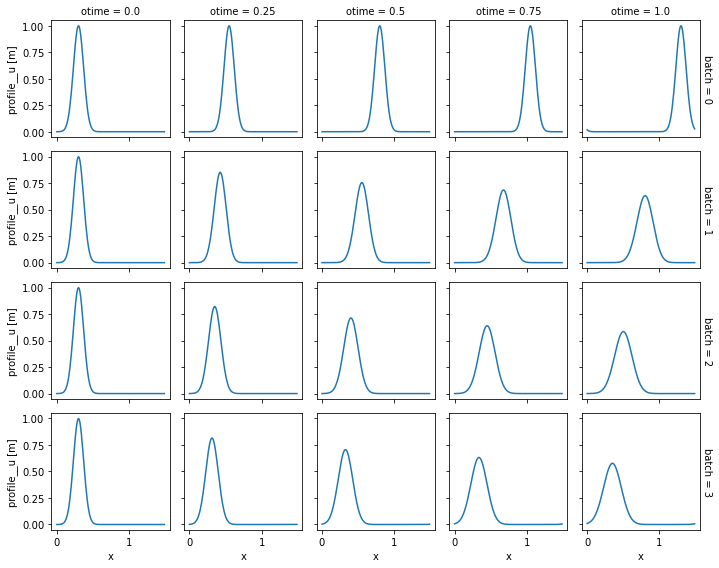

In [71]:
 out_ds_vel.profile__u.plot(row='batch', col='otime', figsize=(10, 8));

In [69]:
#DIFFERENT GAUSSIAN POSITIONS AND A DIFFERENT VELOCITY
in_ds_initloc = in_ds.xsimlab.update_vars(
    model=advect_model,
    input_vars={'init__loc': ('batch', [0.9, 0.5,0.01]),
               'advect__v':(0.2)}#change velocity 
)


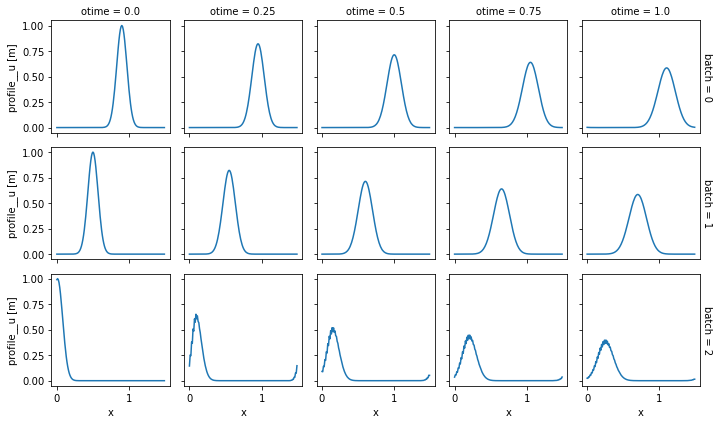

In [70]:
out_ds_initloc = in_ds_initloc.xsimlab.run(model=advect_model, batch_dim='batch')
out_ds_initloc.profile__u.plot(row='batch', col='otime', figsize=(10, 6));

In [74]:
#DIFFERENT GAUSSIAN POSITIONS AND SCALES
in_ds_comb = in_ds.xsimlab.update_vars(
    model=advect_model,
    input_vars={'init__loc': ('batch', [0.3, 0.6, 0.9]),
                'init__scale': ('batch', [0.1, 0.2, 0.3])}
)



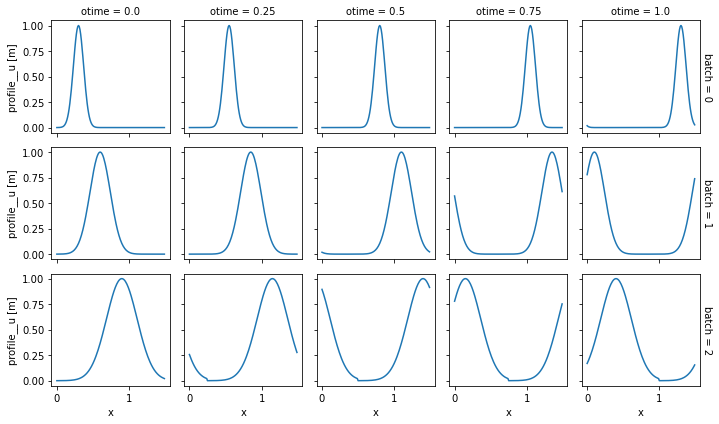

In [75]:
out_ds_comb = in_ds_comb.xsimlab.run(model=advect_model, batch_dim='batch')
out_ds_comb.profile__u.plot(row='batch', col='otime', figsize=(10, 6));

In [92]:
#UPDATE EXISTING MODELS: add a source terme at a specific location
@xs.process
class SourcePoint:
    """Source point for quantity `u`.

    The location of the source point is adjusted to coincide with
    the nearest node the grid.

    """

    loc = xs.variable(description="source location")
    flux = xs.variable(description="source flux")
    x = xs.foreign(UniformGrid1D, "x")
    u_source = xs.variable(dims="x", intent="out", groups="u_vars")

    @property
    def nearest_node(self):
        idx = np.abs(self.x - self.loc).argmin()
        return idx

    @property
    def source_rate(self):
        src_array = np.zeros_like(self.x)#fill with 0
        src_array[self.nearest_node] = self.flux #but not in the nearest node where the u value is flux
        return src_array

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.u_source = self.source_rate * dt#give the position advancement due to the source term, should be added to u_adveced in Profile_U

In [97]:
@xs.process
class InitUFlat:
    """Flat initial profile of `u`."""

    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.zeros_like(self.x)

In [104]:
advect_model_src = advect_model.update_processes(
    {"source": SourcePoint, "init":InitUGauss}
)


In [123]:
#CREATE SET UP 2
in_ds_src = xs.create_setup(model=advect_model_src, 
                        clocks={'time': np.linspace(0., 1., 101),
                                'otime': [0, 0.25, 0.5,0.75, 1]}, 
                        master_clock='time',
                        input_vars={'grid': {'length': 1.5, 'spacing': 0.01},#INITIALISATION
                                    'advect__v': 0.5,
                                    'source':{'loc':0.3, 'flux':50},
                                    'init': {'loc': 0.3, 'scale': 0.1}},
                        output_vars={'profile__u': 'otime'})

In [124]:
out_ds_src = in_ds_src.xsimlab.run(model=advect_model_src)

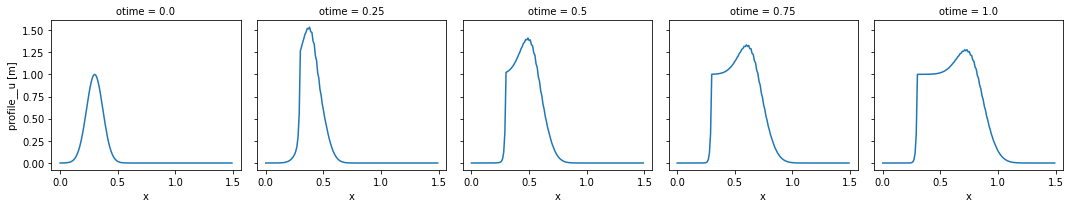

In [125]:
out_ds_src.profile__u.plot(col='otime', figsize=(15, 3));

In [126]:
#HERITAGE: to fixe the parameters of the grid

@xs.process
class FixedGrid(UniformGrid1D):
    spacing = xs.variable(description="uniform spacing", intent="out")
    length = xs.variable(description="total length", intent="out")

    def initialize(self):
        self.spacing = 0.01
        self.length = 1.0
        super(FixedGrid, self).initialize()
        
advect_model_fgrid2 = advect_model.update_processes({"grid": FixedGrid})
        


In [128]:
#CREATE SET UP 2
in_ds_h = xs.create_setup(model=advect_model_fgrid2, 
                        clocks={'time': np.linspace(0., 1., 101),
                                'otime': [0, 0.25, 0.5,0.75, 1]}, 
                        master_clock='time',
                        input_vars={'advect__v': 0.5,
                                    'source':{'loc':0.3, 'flux':50},
                                    'init': {'loc': 0.3, 'scale': 0.1}},
                        output_vars={'profile__u': 'otime'})

In [130]:
out_ds_h = in_ds_h.xsimlab.run(model=advect_model_fgrid2)

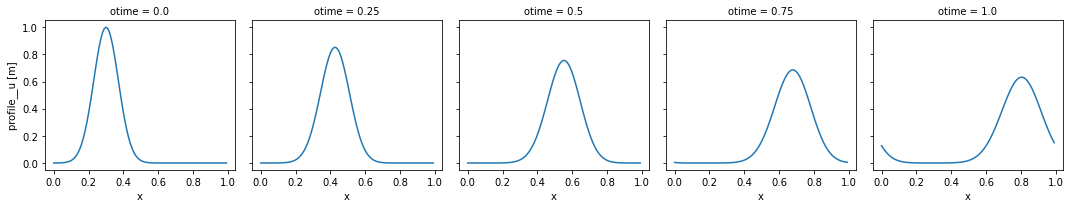

In [131]:
out_ds_h.profile__u.plot(col='otime', figsize=(15, 3));